In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import pandas_datareader as web
import yfinance as yfin


from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
from scipy import stats as stat

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tnrange, tqdm_notebook, tqdm
#from textblob import TextBlob

In [2]:
chunk = pd.read_csv('Bitcoin_tweets.csv',chunksize=100000,lineterminator='\n', dtype='unicode', on_bad_lines='skip')
data = pd.concat(chunk)

In [3]:
data.shape

(4689354, 13)

In [4]:
data.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False
3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,$BTC A big chance in a billion! Price: \487264...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False
4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,This network is secured by 9 508 nodes as of t...,['BTC'],Twitter Web App,False


In [5]:
data.dropna(axis=0 ,subset=['date','text'],inplace = True)
data.reset_index(drop= True,inplace=True)
data.shape

(4689354, 13)

In [6]:
data.drop_duplicates(inplace = True)
data.reset_index(drop=True,inplace=True)
data.shape

(4689354, 13)

In [7]:
data.dtypes

user_name           object
user_location       object
user_description    object
user_created        object
user_followers      object
user_friends        object
user_favourites     object
user_verified       object
date                object
text                object
hashtags            object
source              object
is_retweet          object
dtype: object

In [8]:
data = data.convert_dtypes()
data.dtypes

user_name           string[python]
user_location       string[python]
user_description    string[python]
user_created        string[python]
user_followers      string[python]
user_friends        string[python]
user_favourites     string[python]
user_verified       string[python]
date                string[python]
text                string[python]
hashtags            string[python]
source              string[python]
is_retweet          string[python]
dtype: object

In [9]:
#Check which of the rows don't have an actuall date in the 'date' column
def validate(date_text):
    errors = []
    for i,v in enumerate(date_text):
        try:
            datetime.strptime(v, '%Y-%m-%d %H:%M:%S')
        except ValueError:
            errors.append(i)
    return errors

In [10]:
errors = validate(data['date'])
print('There are '+ str(len(errors)) + ' values that are not actual dates in the date column')

There are 66 values that are not actual dates in the date column


In [11]:
data_clean_date = data.loc[~data.index.isin(errors)]
data_clean_date.reset_index(drop=True,inplace=True)
data_clean_date.shape

(4689288, 13)

In [12]:
data_clean_date['date'] = pd.to_datetime(data_clean_date['date'], format='%Y-%m-%d %H:%M:%S')

/var/folders/06/fb5_7prj0vx1gwz728806g2c0000gn/T/ipykernel_2131/4144265522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean_date['date'] = pd.to_datetime(data_clean_date['date'], format='%Y-%m-%d %H:%M:%S')


In [13]:
data_clean_initial = data_clean_date.loc[(data_clean_date['date'] >= '2022-05-30')].reset_index(drop=True)
data_clean_initial.head()

data_clean_initial["date"]=pd.to_datetime(data_clean_initial["date"],errors='coerce')
data_clean_initial["date"]=data_clean_initial["date"].apply(lambda x: x.date() )
data_clean_initial.head()


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,trm_crypto,United States,This is the trm_crypto channel and I want to b...,2021-11-05 14:08:29,50.0,644.0,348.0,False,2022-06-04,$1 billion has been lost in cryptocurrency sca...,"['trm', 'trm_crypto', 'Bitcoin', 'Etherium', '...",IFTTT,False
1,trm_crypto,United States,This is the trm_crypto channel and I want to b...,2021-11-05 14:08:29,50.0,644.0,348.0,False,2022-06-04,Is Solana a 'buy' with SOL price at 10-month l...,"['trm', 'trm_crypto', 'Bitcoin', 'Etherium', '...",IFTTT,False
2,trm_crypto,United States,This is the trm_crypto channel and I want to b...,2021-11-05 14:08:29,50.0,644.0,348.0,False,2022-06-04,Russia's Industrial Giant Rostec Announces Blo...,"['trm', 'trm_crypto', 'Bitcoin', 'Etherium', '...",IFTTT,False
3,CrypticThreadz.NFT,Metaverse,News collected from multiple top sources in on...,2021-07-17 23:56:22,265.0,81.0,94.0,False,2022-06-04,Alchemy announces support for Solana Web3 appl...,"['bitcoin', 'cryptocurrency', 'crypto', 'nft',...",Blogtotwitter1950,False
4,Freelance Jobs Feed,<NA>,Follow here for Hourly Freelance Job Posts | S...,2011-12-24 00:26:53,13050.0,6.0,0.0,False,2022-06-04,#Bitcoin #Blockchain Blockfriend nft bot: I ne...,"['Bitcoin', 'Blockchain']",dlvr.it,False


In [14]:
irrelevant_hashtags = ['nft','giveaway','cashback','airdrop']

In [15]:
data_clean_initial['hashtags'] = data_clean_initial['hashtags'].str.lower()

In [16]:
data_clean_initial = data_clean_initial[data_clean_initial['hashtags'].str.contains('|'.join(irrelevant_hashtags)) == False].reset_index(drop = True)

In [17]:
data_clean_initial["hashtags"]=data_clean_initial["hashtags"].apply(lambda s : s[1:-1].split(',') if isinstance(s,str) else [])
data_clean_initial["hashtags_len"]=data_clean_initial["hashtags"].apply(len)

In [18]:
data_clean_initial.shape

(1103654, 14)

In [19]:
data_clean_initial['text'] = data_clean_initial['text'].str.replace("(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"," ")


In [20]:
def conv_to_float(val):
    return float(val)
data_clean_initial["user_followers"]=data_clean_initial["user_followers"].apply(lambda x : conv_to_float(x))
data_clean_initial["user_friends"]=data_clean_initial["user_friends"].apply(lambda x : conv_to_float(x))
data_clean_initial["user_favourites"]=data_clean_initial["user_favourites"].apply(lambda x : conv_to_float(x))

In [21]:
def generate_reputation(tweet):
    coef_verified = 1.1 if tweet.user_verified else 1
    coef_hashtags = 1+(tweet.hashtags_len/20)
    return ((tweet.user_followers + (tweet.user_friends/4))*coef_verified*coef_hashtags)/100

In [22]:
data_clean_initial["reputation"]=data_clean_initial.apply(generate_reputation, axis=1)

In [23]:
data_clean = data_clean_initial.copy()
data_clean.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,hashtags_len,reputation
0,trm_crypto,United States,This is the trm_crypto channel and I want to b...,2021-11-05 14:08:29,50.0,644.0,348.0,False,2022-06-04,$1 billion has been lost in cryptocurrency sca...,"['trm', 'trm_crypto', 'bitcoin', 'etherium'...",IFTTT,False,6,3.017300
1,trm_crypto,United States,This is the trm_crypto channel and I want to b...,2021-11-05 14:08:29,50.0,644.0,348.0,False,2022-06-04,Is Solana a 'buy' with SOL price at 10-month l...,"['trm', 'trm_crypto', 'bitcoin', 'etherium'...",IFTTT,False,6,3.017300
2,trm_crypto,United States,This is the trm_crypto channel and I want to b...,2021-11-05 14:08:29,50.0,644.0,348.0,False,2022-06-04,Russia's Industrial Giant Rostec Announces Blo...,"['trm', 'trm_crypto', 'bitcoin', 'etherium'...",IFTTT,False,6,3.017300
3,Freelance Jobs Feed,<NA>,Follow here for Hourly Freelance Job Posts | S...,2011-12-24 00:26:53,13050.0,6.0,0.0,False,2022-06-04,#Bitcoin #Blockchain Blockfriend nft bot: I ne...,"['bitcoin', 'blockchain']",dlvr.it,False,2,157.923150
4,Alex,"Havana, Cuba",#Bitcoin 💎🙌🏻 #CryptoTrader📈📉,2020-12-31 21:48:00,153.0,127.0,7294.0,False,2022-06-04,@hfangca #Bitcoin is freedom for me. It's a wa...,['bitcoin'],Twitter Web App,False,1,2.133863


In [24]:
!pip install yfinance

In [25]:
import yfinance as yf
btc_stock=yf.Ticker("BTC-USD")

In [26]:
start = min(data_clean['date'])
end = max(data_clean['date'])
btc_stock = btc_stock.history(start=start, end=end)

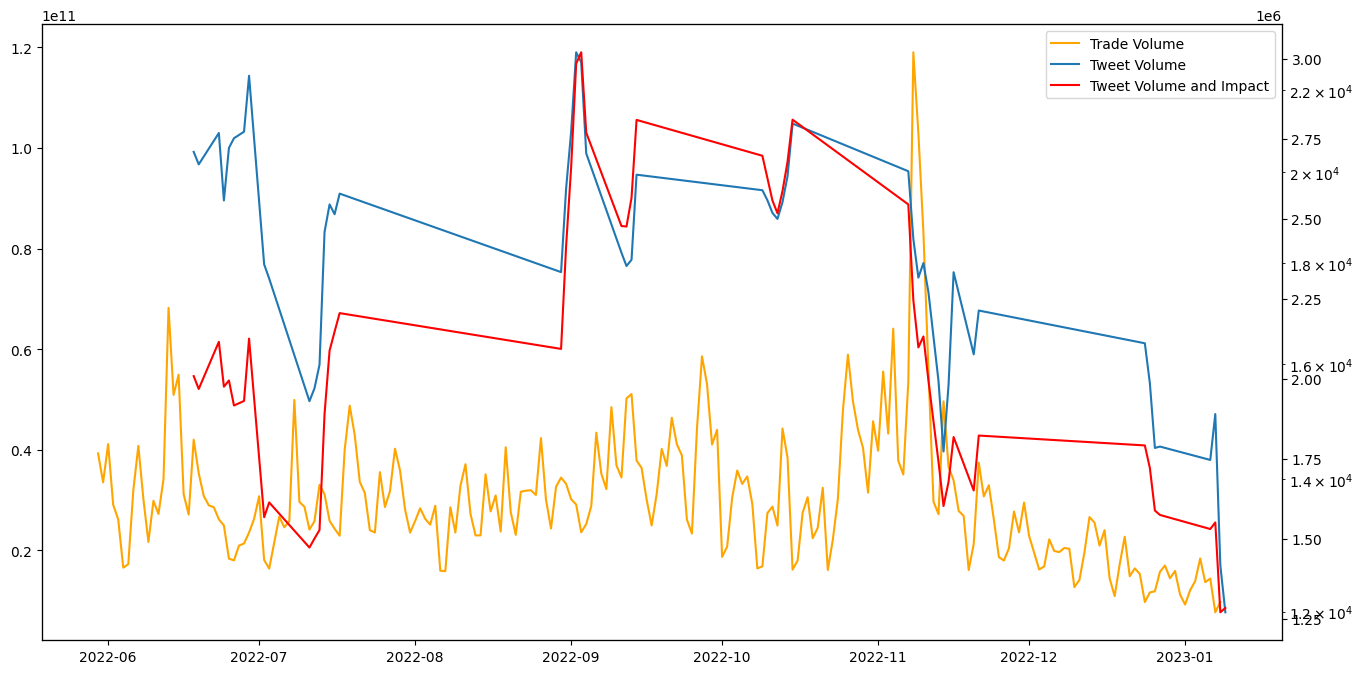

Spearman correlation - tweets: corr=nan pval=nan
Spearman correlation - impact tweets: corr=nan pval=nan


In [27]:
tweet_shift1 = data_clean.groupby('date').size().shift(-1).dropna() 
tweet_shift1_impact = data_clean.groupby('date')["reputation"].sum().shift(-1).dropna() 

tweet_shift1.head()

stocks_data = (btc_stock['Volume']).dropna()

tweets_vol = data_clean.groupby('date').size().rolling(10).mean().dropna()
tweets_vol_impact= data_clean.groupby('date')["reputation"].sum().rolling(10).mean().dropna()

first = tweets_vol.reindex(stocks_data.index)
second = tweets_vol_impact.reindex(stocks_data.index)

corr, pval = stat.spearmanr(first, stocks_data,nan_policy='omit')
corr_i, pval_i = stat.spearmanr(second, stocks_data,nan_policy='omit')

fig, ax = plt.subplots(figsize=(16,8))

ax.plot(stocks_data.index,stocks_data,color='orange',label='Trade Volume')
ax.tick_params(axis='y')

ax2 = ax.twinx()
ax2.plot(tweets_vol.index,tweets_vol,label='Tweet Volume')
ax2.set_yscale('log')
ax2.tick_params(axis='y')

ax3=ax.twinx()
ax3.plot(tweets_vol_impact.index,tweets_vol_impact,label='Tweet Volume and Impact', color='red')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax2.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc=0)

plt.show()

print("Spearman correlation - tweets: corr={} pval={}".format(corr,pval))
print("Spearman correlation - impact tweets: corr={} pval={}".format(corr_i,pval_i))

In [28]:
data_clean['date'] = pd.to_datetime(data_clean['date'],utc=True)
data_clean.date = data_clean.date.dt.tz_localize(None)
data_clean.index = data_clean['date']


In [29]:
analyzer = SentimentIntensityAnalyzer()
compound = []
for i,s in enumerate(tqdm(data_clean['text'],position=0, leave=True)):
    # print(i,s)
    vs = analyzer.polarity_scores(str(s))
    compound.append(vs["compound"])
data_clean["compound"] = compound

100%|██████████| 1103654/1103654 [01:54<00:00, 9599.31it/s] 


In [55]:
stocks_data = stocks_data.tz_localize(None)

In [32]:
def crosscorr(datax, datay, lag=0, method="pearson"):
    #Lag-N cross correlation
    return datax.corrwith(datay.shift(lag), method=method)['score']

In [56]:
xcov = [crosscorr(data_clean, stocks_data, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(data_clean, stocks_data, lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(data_clean, stocks_data, lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

In [ ]:
def get_polarity_cat(score):
    if score >=0.05 : 
        return "positive"
    elif score <=-0.05:
        return "negative"
    else:
        return "neutral"

data_clean["polarity_cat"]=data_clean["polarity_score"].apply(get_polarity_cat)